In [8]:
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator


def create_model():
    m = ConcreteModel()

    m.t = ContinuousSet(bounds=(0.0, 10.0))

    m.b = Param(initialize=0.25)
    m.c = Param(initialize=5.0)

    m.omega = Var(m.t)
    m.theta = Var(m.t)

    m.domegadt = DerivativeVar(m.omega, wrt=m.t)
    m.dthetadt = DerivativeVar(m.theta, wrt=m.t)

    # Setting the initial conditions
    m.omega[0] = 0.0
    m.theta[0] = 3.14 - 0.1

    def _diffeq1(m, t):
        return m.domegadt[t] == -m.b * m.omega[t] - m.c * sin(m.theta[t])
    m.diffeq1 = Constraint(m.t, rule=_diffeq1)

    def _diffeq2(m, t):
        return m.dthetadt[t] == m.omega[t]
    m.diffeq2 = Constraint(m.t, rule=_diffeq2)

    return m


def simulate_model(m):
    if False:
        # Simulate the model using casadi
        sim = Simulator(m, package='casadi')
        tsim, profiles = sim.simulate(numpoints=100, integrator='cvodes')
    else:
        # Simulate the model using scipy
        sim = Simulator(m, package='scipy')
        tsim, profiles = sim.simulate(numpoints=100, integrator='vode')

    # Discretize model using Orthogonal Collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe=8, ncp=5)

    # Initialize the discretized model using the simulator profiles
    sim.initialize_model()

    return sim, tsim, profiles


def plot_result(m, sim, tsim, profiles):
    import matplotlib.pyplot as plt

    time = list(m.t)
    omega = [value(m.omega[t]) for t in m.t]
    theta = [value(m.theta[t]) for t in m.t]

    varorder = sim.get_variable_order()

    for idx, v in enumerate(varorder):
        plt.plot(tsim, profiles[:, idx], label=v)
    plt.plot(time, omega, 'o', label='omega interp')
    plt.plot(time, theta, 'o', label='theta interp')
    plt.xlabel('t')
    plt.legend(loc='best')
    plt.show()

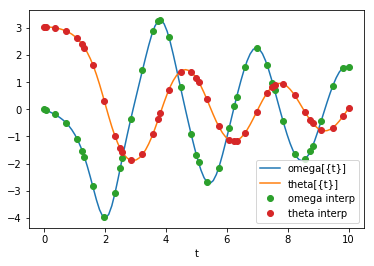

In [9]:
%matplotlib inline

model = create_model()
sim, tsim, profiles = simulate_model(model)
plot_result(model, sim, tsim, profiles)